# ITCS 3156-091 Final Project: Steam Review Sentiment Analysis

## Name: **Jason Khotsombath**

### Imports, Installs, and Utils

In [38]:
%pip install wordcloud
%pip install nltk
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [39]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Steam Review Dataset

<center><img src="https://storage.googleapis.com/kaggle-datasets-images/1754525/2865229/aacab271ac39a043c556e617d148bb94/dataset-cover.png?t=2021-11-29-10-49-35"
width="600"
height="300"></img></center>

For my project, we will be using the [Steam Review Dataset](https://www.kaggle.com/datasets/andrewmvd/steam-reviews/data) by user [Larxel](https://www.kaggle.com/andrewmvd). This dataset contains 6.4 million publically available English reviews of from the Steam Reviews segment of the Steam store ran by Valve in 2017. On the Kaggle, the author suggests you can create a sentiment analysis algorithm to predict scores given review text and explore sentiment with review topics across games and genres. We will be doing the first option to predict scores based on review text. This is important specifically for game developers to understand player reception to their games, trend analysis for specific mechanics based on review text, and allows insights into what features/mechanics players value the most.

**Inputs/Features**

| Name                          | Data Name   | Description | Provided in Dataset |
|-------------------------------|------------|-------------|---------------|
| Game ID                    | app_id               | Unique ID of the game stored in the Steam Database | True |
| Game Name              | app_name         | Name of the Game stored in the Steam Database | True 
| Review Text                 | review_text          | The text input of the review text for that review | True |
| Review Text Word Count         | word_count | Number of words in the Review Text of that review | False |
| Review Votes | review_votes | Whether the review was recommended by another user or not | True |

**Target**

| Name                          | Data Name  | Description | Provided in Dataset |
|-------------------------------|-------------|-------------|----|
| Review Score | review_score     |  Whether the review recommends the game or not | True |

# Data Loading

In [40]:
# Make sure you download the dataset and place it in the same directory as this file.
# If the dataset is named as "dataset.csv", rename it to "SteamReviews.csv"
# Warning: The dataset is large, ~1-1.5min to load
steam_reviews_df = pd.read_csv('SteamReviews.csv')

In [41]:
# Sample Size
# steam_reviews_df = steam_reviews_df.sample(n=10000, random_state=np.random.randint(0,10000))
steam_reviews_df = steam_reviews_df.sample(n=10000, random_state=42)

In [42]:
# Adding Word Count as a feature
steam_reviews_df['word_count'] = steam_reviews_df['review_text'].str.split().str.len()

In [43]:
steam_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 301327 to 2910898
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   app_id        10000 non-null  int64  
 1   app_name      9717 non-null   object 
 2   review_text   9989 non-null   object 
 3   review_score  10000 non-null  int64  
 4   review_votes  10000 non-null  int64  
 5   word_count    9989 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 546.9+ KB


In [44]:
steam_reviews_df.describe()

,app_id,review_score,review_votes,word_count
count,10000.000000,10000.000000,10000.000000,9989.000000
mean,229031.791300,0.632400,0.148200,55.609270
std,124891.034596,0.774681,0.355316,109.781069
min,10.000000,-1.000000,0.000000,0.000000
25%,202970.000000,1.000000,0.000000,6.000000
50%,240760.000000,1.000000,0.000000,20.000000
75%,304930.000000,1.000000,0.000000,57.000000
max,556130.000000,1.000000,1.000000,1363.000000


# Visualization

## Numeric Features
### Correlation between all numeric features

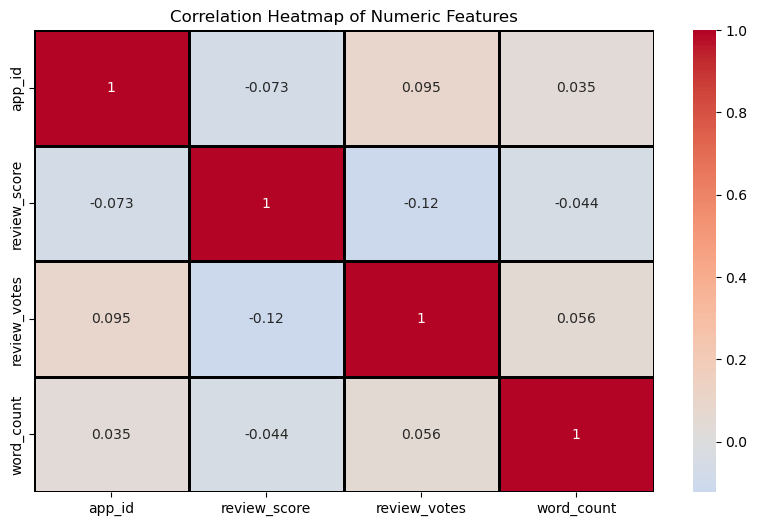

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = steam_reviews_df.drop(columns=['review_text', 'app_name'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black'),
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## Word Count by Sentiment
### Distribution of word count by sentiment

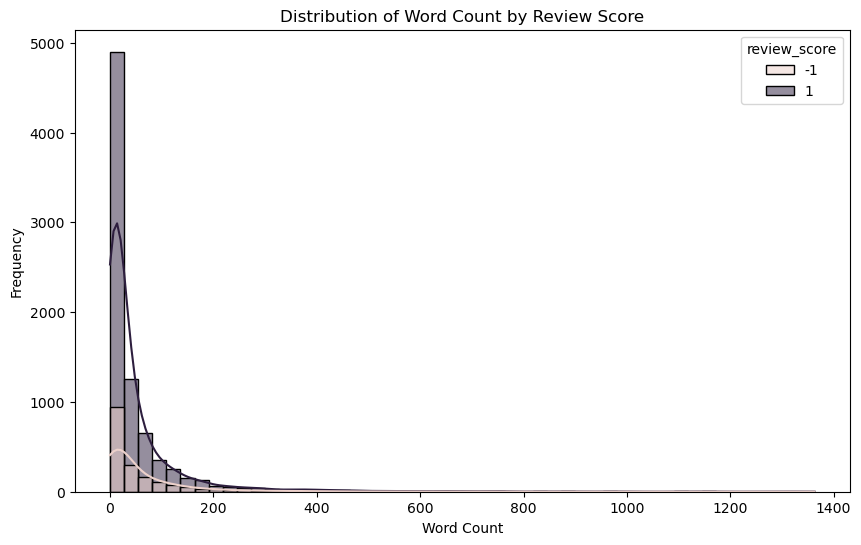

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(data=steam_reviews_df, x='word_count', hue='review_score', bins=50, kde=True)
plt.title('Distribution of Word Count by Review Score')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Game Distribution
### Top Games by review count
Note: Game Distribution varies greatly due to the chosen random seed and n sample size. These games do not accurately suggest the amount of review that they may actually have, nor be as high as other games. Everytime steam_reviews_df is read and give its smaller sample, this list may change.

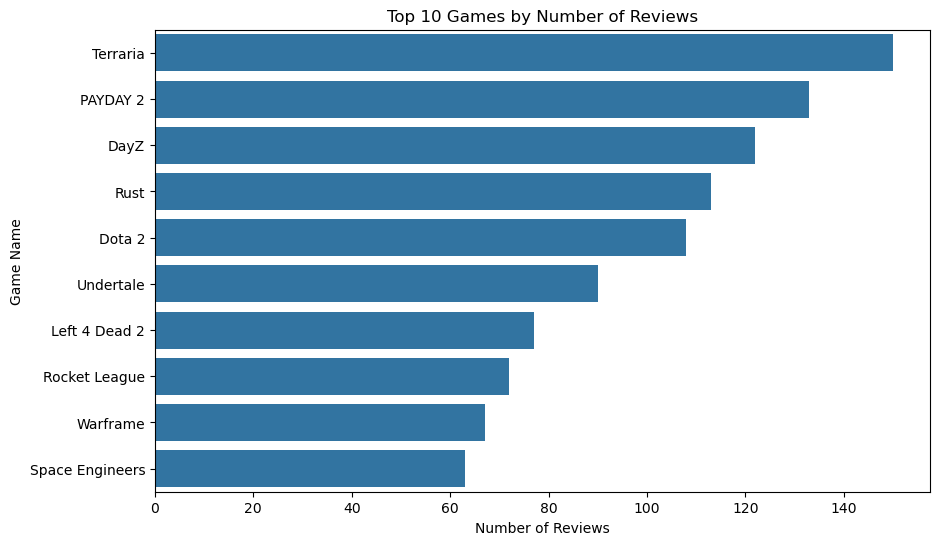

In [47]:
top_games_df = steam_reviews_df['app_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_games_df.values, y=top_games_df.index)
plt.title('Top 10 Games by Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Game Name')
plt.show()

## Sentiment Score Distribution
### Pie Chart of Postive to Negative Reviews

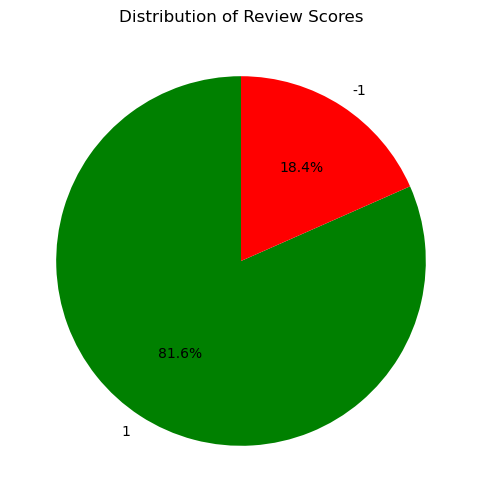

In [48]:
plt.figure(figsize=(10, 6))
steam_reviews_df['review_score'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('Distribution of Review Scores')
plt.ylabel('')
plt.show()

## Word Cloud
### Word clouds of the most common words for positive and negative reviews.

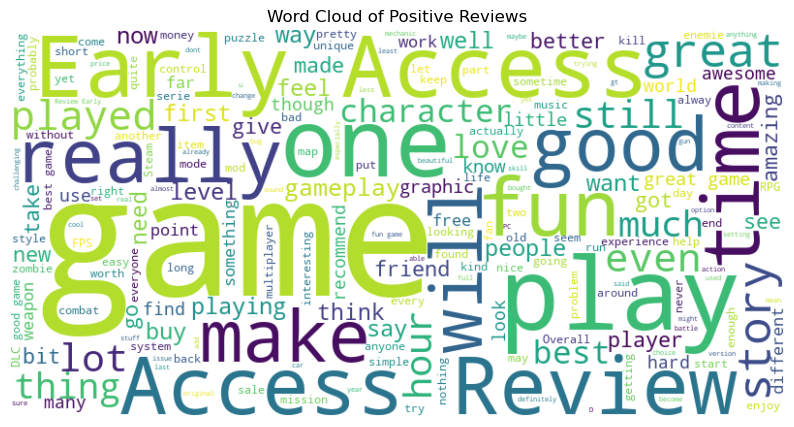

In [49]:
from wordcloud import WordCloud

steam_reviews_df['review_text'] = steam_reviews_df['review_text'].astype(str).replace('nan', '')
positive_text = ' '.join(steam_reviews_df[steam_reviews_df['review_score'] == 1]['review_text'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

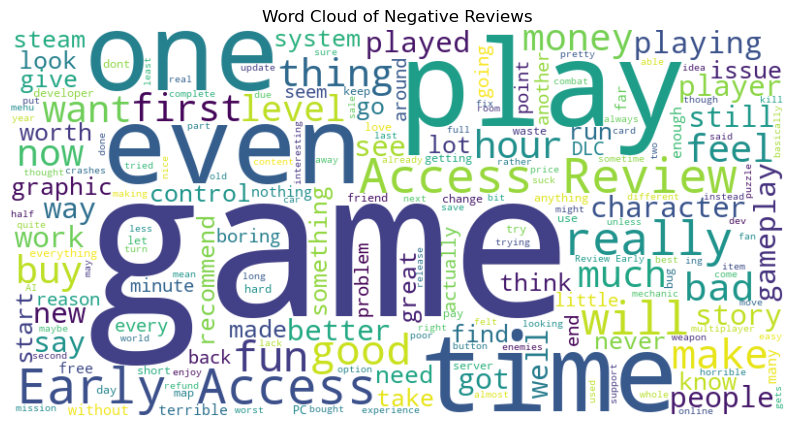

In [50]:
negative_text = ' '.join(steam_reviews_df[steam_reviews_df['review_score'] == -1]['review_text'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

## Review Length by Sentiment
### Correlation between the review score and the word count of the review.

Text(0, 0.5, 'Word Count')

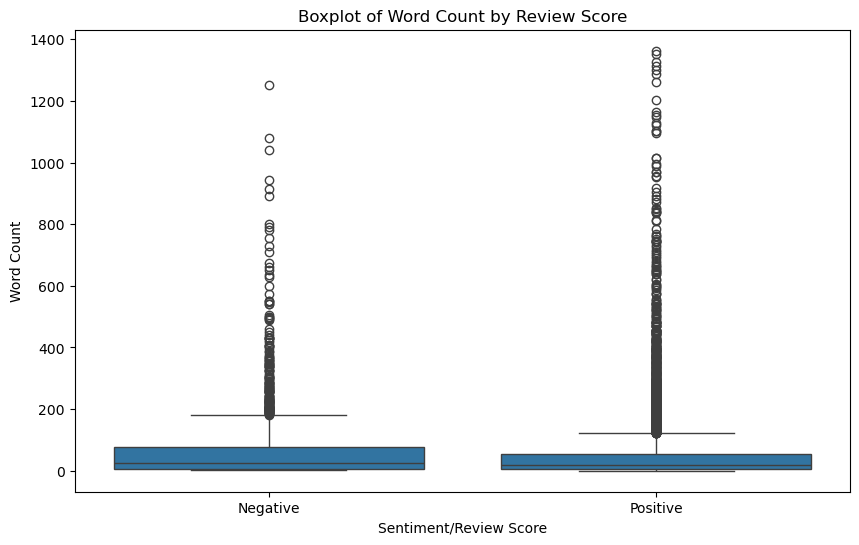

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='word_count', data=steam_reviews_df)
plt.title('Boxplot of Word Count by Review Score')
plt.xlabel('Sentiment/Review Score')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.ylabel('Word Count')

# Data Splitting and Preprocessing 

## Text Preprocessing
The usage of text preprocessing is removing unnessecary values in our dataset such as: HTML Tags, URLs, special characters and numbers, and stop words (the, and, a, etc...). Additionally, we're tokenizing each of the words and pushing through a lemmatization tool (WordNet Lemmatizer).

In [52]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)

nltk.download('punkt', download_dir=nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
nltk.download('wordnet', download_dir=nltk_data_path)


def preprocess_text(text:str) -> str:
    """
    Preprocess the text by removing special characters, converting to lowercase,
    removing stopwords, and lemmatizing the words.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: The cleaned and preprocessed text.
    """

    if not isinstance(text, str):
        return ''
    
    # Lowercase text
    text = text.lower()

    # Remove HTML tags, special characters, numbers, and URLs
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Tokenize input
    nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
    os.makedirs(nltk_data_path, exist_ok=True)
    nltk.data.path.insert(0, nltk_data_path)

    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Puts tokens back into a string
    processed_text = ' '.join(tokens)
    # print (f"Processed text: {processed_text}")
    return processed_text


[nltk_data] Downloading package punkt to
[nltk_data]     c:\Users\jason\Documents\VSCode\ITCS_3156\Steam-
[nltk_data]     Review-Sentiment-Analysis\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\Users\jason\Documents\VSCode\ITCS_3156\Steam-
[nltk_data]     Review-Sentiment-Analysis\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\jason\Documents\VSCode\ITCS_3156\Steam-
[nltk_data]     Review-Sentiment-Analysis\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\jason\Documents\VSCode\ITCS_3156\Steam-
[nltk_data]     Review-Sentiment-Analysis\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Feature Extraction
Here we're extracting additional features to aid in predicating review/sentiment score. These values often correlate to review score.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

def extract_features(df: pd.DataFrame, feature_extraction_method: str = 'tfidf') -> Tuple[object, object]:
    """
    Extract features from the review text using TF-IDF or Count Vectorization.

    Args:
        df (pd.DataFrame): The DataFrame containing the preprocessed text.
        feature_extraction_method (str): The method to use for feature extraction ('tfidf').

    Returns:
        Tuple: [X_train, y_train, X_valid, y_valid, X_test, y_test, vectorizer]
    """

    df['processed_text'] = df['review_text'].apply(preprocess_text)

    df['word_count'] = df['processed_text'].str.split().str.len()
    df['char_count'] = df['processed_text'].str.len()
    df['avg_word_length'] = df.apply(lambda x: x['char_count'] / x['word_count'] if x['word_count'] > 0 else 0, axis=1)
    df['punctuation_count'] = df['processed_text'].str.count(r'[^\w\s]')

    # Extract features using TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=5000)
    text_features = vectorizer.fit_transform(df['processed_text']).toarray()

    additional_features = df[['word_count', 'char_count', 'avg_word_length', 'punctuation_count']].values

    # Convert to sparse matrix
    X = np.hstack((text_features, additional_features))
    y = df['review_score'].values

    X_trn, X_tst, y_trn, y_tst =  train_test_split(X, y, test_size=0.2, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.25, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer

## Data Processing
### Putting it all together

In [54]:
def get_preprocessed_data(df: pd.DataFrame, feature_extraction_method: str = 'tfidf') -> Tuple[object, object]:
    """
    Preprocess the data and extract features.

    Args:
        df (pd.DataFrame): The DataFrame containing the review text.
        feature_extraction_method (str): The method to use for feature extraction ('tfidf').

    Returns:
        Tuple: [X_train, y_train, X_valid, y_valid, X_test, y_test]
    """

    # Data Safety Check
    df['review_score'] = df['review_score'].apply(lambda x: 1 if x == 1 else -1)

    # Preprocess the data and extract features
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = extract_features(df, feature_extraction_method)

    text_feature_count = X_trn.shape[1] - 4  # Subtracting the number of additional features
    scaler = sklearn.preprocessing.StandardScaler()

    X_trn[:, -text_feature_count:] = scaler.fit_transform(X_trn[:, -text_feature_count:])
    X_vld[:, -text_feature_count:] = scaler.transform(X_vld[:, -text_feature_count:])
    X_tst[:, -text_feature_count:] = scaler.transform(X_tst[:, -text_feature_count:])

    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1), vectorizer

In [55]:
def test_data_preprocessing_pipeline(df: pd.DataFrame = steam_reviews_df) -> bool:
    """
    Test the text preprocessing pipeline with sample reviews.
    """

    print("Testing the text preprocessing pipeline...")

    # Text Preprocessing Test
    sample_text = 'This is a www.testingL!ink.com with 123 numbers, <html> <b>tags</b>, and some punctuation!'
    processed = preprocess_text(sample_text)
    print(f"Original text: {sample_text}")
    print(f"Processed text: {processed}")

    assert isinstance(processed, str), "Processed text should be a string."
    assert len(processed) > 0, "Processed text should not be empty."
    assert all(char.isalpha() or char.isspace() for char in processed), "Processed text should only contain letters and spaces."
    assert 'www' not in processed, "Processed text should not contain URLs."
    assert '<html>' not in processed, "Processed text should not contain HTML tags."
    assert '123' not in processed, "Processed text should not contain numbers."
    assert '!' not in processed, "Processed text should not contain punctuation."

    print("Basic Text Processing Test passed!")

    test_df = df.head(100).copy()

    # Shape Test
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = extract_features(test_df)
    assert X_trn.shape[0] + X_vld.shape[0] + X_tst.shape[0] == 100, "Data split should preserve the number of samples."
    assert X_trn.shape[1] == X_vld.shape[1] == X_tst.shape[1], "Feature dimensions should match across splits."

    # Feature List Test
    assert 'word_count' in test_df.columns, "word_count should be in the DataFrame."
    assert 'char_count' in test_df.columns, "char_count should be in the DataFrame."
    assert 'avg_word_length' in test_df.columns, "avg_word_length should be in the DataFrame."
    assert 'punctuation_count' in test_df.columns, "punctuation_count should be in the DataFrame."

    # word_count Test
    sample_row = test_df.iloc[0]
    expected_word_count = len(sample_row['processed_text'].split())
    print(f"Sample processed text: {sample_row['processed_text']}")
    print(f"Expected word count: {expected_word_count}")
    assert sample_row['word_count'] == expected_word_count, "word_count should match the number of words in processed_text."
    print(f"Actual word count: {sample_row['word_count']}")

    print("Feature Extraction Test passed!")

    # Vectorizer Test
    vocab = vectorizer.get_feature_names_out()
    print(f"Vocabulary size: {len(vocab)}")
    assert len(vocab) > 0, "Vectorizer should have a non-empty vocabulary."
    assert len(vocab) <= 5000, "Vectorizer should have, at most, 5000 features."

    new_text = "This game is amazing!"
    new_text_vectorized = preprocess_text(new_text)
    transformed_text = vectorizer.transform([new_text_vectorized]).toarray()

    print(f"Transformed text shape: {transformed_text.shape}")
    print(f'Transformed text: {transformed_text}')
    assert transformed_text.shape[1] == len(vocab), "Transformed text should have the same number of features as the vocabulary."
    assert transformed_text.shape[0] == 1, "Transformed text should have one row."

    print("Vectorizer Test passed!")

    # End to End Test
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = get_preprocessed_data(test_df)

    text_feature_count = X_trn.shape[1] - 4  # Subtracting the number of additional features
    additional_feature_count = X_trn[:, text_feature_count:]
    assert abs(additional_feature_count.mean()) < 0.1, "Additional features should be centered around 0."
    assert abs(additional_feature_count.std() - 1.0) > 0.1, "Additional features should have some variance."

    print("End to End Test passed!")

    # Transformation Test
    assert set(np.unique(y_trn)) <= {-1, 1}, "y_train should only contain -1 and 1."
    assert y_trn.shape[1] == 1, "y_train should be a 2D array with one column."

    print("Transformation Test passed!")

    print("All tests passed!")
    return True


test_data_preprocessing_pipeline(steam_reviews_df)

Testing the text preprocessing pipeline...
Original text: This is a www.testingL!ink.com with 123 numbers, <html> <b>tags</b>, and some punctuation!
Processed text: number tag punctuation
Basic Text Processing Test passed!
Sample processed text: best bowling simulator good storyline
Expected word count: 5
Actual word count: 5
Feature Extraction Test passed!
Vocabulary size: 1105
Transformed text shape: (1, 1105)
Transformed text: [[0. 0. 0. ... 0. 0. 0.]]
Vectorizer Test passed!
End to End Test passed!
Transformation Test passed!
All tests passed!


True

# Metrics

## Multinomial Naives Bayes
Here we are using sklearn's multinomial Naive Bayes as opposed to the Gaussian Naives Bayes in class. Multinomial Naive Bayes has a few advanatages when it comes to this specific project.<br><br>
&#x2022; Ideal for discrete data and used in text classification; hence used in NLP<br>
&#x2022; Models frequency of words as counts<br>
&#x2022; More efficient with a higher number of features like datasets with thousands of words<br>
&#x2022; Doesn't assume or follow a gaussian distribution for likelihood<br><br>

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import sklearn.preprocessing

def evaluate_naive_bayes_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst):
    """
    Train and evaluate the Multinomial Naive Bayes Model.

    Args:
        X_trn (np.ndarray): Training feature set.
        y_trn (np.ndarray): Training labels.
        X_vld (np.ndarray): Validation feature set.
        y_vld (np.ndarray): Validation labels.
        X_tst (np.ndarray): Test feature set.
        y_tst (np.ndarray): Test labels.


    """

    num_features = X_trn.shape[1]
    num_additional_features = 4
    text_feature_count = num_features - num_additional_features

    # Ensures non-negative values for TF-IDF features
    X_trn_tfidf = X_trn[:, :text_feature_count]
    X_vld_tfidf = X_vld[:, :text_feature_count]
    X_tst_tfidf = X_tst[:, :text_feature_count]

    X_trn_tfidf = np.maximum(0, X_trn_tfidf)
    X_vld_tfidf = np.maximum(0, X_vld_tfidf)
    X_tst_tfidf = np.maximum(0, X_tst_tfidf)

    scaler = sklearn.preprocessing.MinMaxScaler()
    X_trn_additional = X_trn[:, text_feature_count:]
    X_vld_additional = X_vld[:, text_feature_count:]
    X_tst_additional = X_tst[:, text_feature_count:]
    X_trn_additional = scaler.fit_transform(X_trn_additional)
    X_vld_additional = scaler.transform(X_vld_additional)
    X_tst_additional = scaler.transform(X_tst_additional)

    # Combine TF-IDF and additional features
    X_trn_nb = np.hstack((X_trn_tfidf, X_trn_additional))
    X_vld_nb = np.hstack((X_vld_tfidf, X_vld_additional))
    X_tst_nb = np.hstack((X_tst_tfidf, X_tst_additional))


    # Data Preprocessing for **Multinomial** Naive Bayes
    # Convert y to binary values (0 and 1) for Multinomial Naive Bayes
    y_trn_nb = (y_trn.reshape(-1) + 1) // 2
    y_vld_nb = (y_vld.reshape(-1) + 1) // 2
    y_tst_nb = (y_tst.reshape(-1) + 1) // 2

    # Hyperparameter Tuning
    param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    }

    nb_model = MultinomialNB()

    grid_search = GridSearchCV(nb_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_trn_nb, y_trn_nb)

    best_model = grid_search.best_estimator_
    print(f'Best parameters: {grid_search.best_params_}')

    # Performance Evaluation on Validation Set
    y_vld_pred = best_model.predict(X_vld_nb)

    accuracy = accuracy_score(y_vld_nb, y_vld_pred)
    precision = precision_score(y_vld_nb, y_vld_pred, zero_division=0)
    recall = recall_score(y_vld_nb, y_vld_pred, zero_division=0)
    f1 = f1_score(y_vld_nb, y_vld_pred, zero_division=0)

    y_vld_proba = best_model.predict_proba(X_vld_nb)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_vld_nb, y_vld_proba)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_vld_nb, y_vld_pred)

    print(f'Validation Accuracy: {accuracy}')
    print(f'Validation Precision: {precision}')
    print(f'Validation Recall: {recall}')
    print(f'Validation F1 Score: {f1}')
    print(f'Validation ROC AUC: {roc_auc}')

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

    # Plotting the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Neural Network')
    plt.legend(loc='lower right')
    plt.show()

    # Feature Importance
    if hasattr(best_model, 'feature_log_prob_'):
        feature_importance = best_model.feature_log_prob_[1] - best_model.feature_log_prob_[0]

        n_features = 20
        indices = np.argsort(feature_importance)
        top_negative_features = indices[:n_features]
        top_positive_features = indices[-n_features:][::-1]

        print('Top Positive Features:')
        for i in top_positive_features:
            if i < len(feature_importance) - 4:
                print(f'{i}: {feature_importance[i]}')
        
        print('\nTop Negative Features:')
        for i in top_negative_features:
            if i < len(feature_importance) - 4:
                print(f'{i}: {feature_importance[i]}')

    # Performance Evaluation on Test Set
    y_tst_pred = best_model.predict(X_tst_nb)

    test_accuracy = accuracy_score(y_tst_nb, y_tst_pred)
    test_precision = precision_score(y_tst_nb, y_tst_pred, zero_division=0)
    test_recall = recall_score(y_tst_nb, y_tst_pred, zero_division=0)
    test_f1 = f1_score(y_tst_nb, y_tst_pred, zero_division=0)
    test_roc_auc = auc(fpr, tpr)

    y_tst_proba = best_model.predict_proba(X_tst_nb)[:, 1]
    test_fpr, test_tpr, test_thresholds = roc_curve(y_tst_nb, y_tst_proba)
    test_roc_auc = auc(test_fpr, test_tpr)

    print('Test Metrics:')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Recall: {test_recall}')
    print(f'Test F1 Score: {test_f1}')
    print(f'Test ROC AUC: {test_roc_auc}')

    # Storing metrics
    metrics = {
        'model_name': 'Multinomial Naive Bayes',
        'best_params': grid_search.best_params_,
        'validation': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'roc_auc': test_roc_auc,
            'fpr': test_fpr,
            'tpr': test_tpr,
        }
    }

    return best_model, metrics


In [57]:
import tensorflow as tf

def evaluate_neural_network_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst):
    """
    Train and evaluate a Neural Network model.

    Args:
        X_trn (np.ndarray): Training feature set.
        y_trn (np.ndarray): Training labels.
        X_vld (np.ndarray): Validation feature set.
        y_vld (np.ndarray): Validation labels.
        X_tst (np.ndarray): Test feature set.
        y_tst (np.ndarray): Test labels.

    Returns:
        Tuple: [model, metrics]
    """

    tf.random.set_seed(42)
    input_dim = X_trn.shape[1]

    # Define the Neural Network model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early Stopping Callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    y_trn_nn = (y_trn.reshape(-1) + 1) // 2
    y_vld_nn = (y_vld.reshape(-1) + 1) // 2
    y_tst_nn = (y_tst.reshape(-1) + 1) // 2

    # Train the model
    history = model.fit(X_trn, y_trn_nn, epochs=10, batch_size=32, validation_data=(X_vld, y_vld_nn), verbose=1)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Performance Evaluation on Validation Set
    y_vld_proba = model.predict(X_vld, verbose=0)
    y_vld_pred = (y_vld_proba > 0.5).astype(int).reshape(-1)

    accuracy = accuracy_score(y_vld_nn, y_vld_pred)
    precision = precision_score(y_vld_nn, y_vld_pred, zero_division=0)
    recall = recall_score(y_vld_nn, y_vld_pred, zero_division=0)
    f1 = f1_score(y_vld_nn, y_vld_pred, zero_division=0)
    fpr, tpr, thresholds = roc_curve(y_vld_nn, y_vld_proba)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_vld_nn, y_vld_pred)

    # Validation Metrics
    print(f'Validation Accuracy: {accuracy}')
    print(f'Validation Precision: {precision}')
    print(f'Validation Recall: {recall}')
    print(f'Validation F1 Score: {f1}')
    print(f'Validation ROC AUC: {roc_auc}')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix - Neural Network')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Neural Network')
    plt.legend(loc='lower right')
    plt.show()

    # Performance Evaluation on Test Set
    y_tst_proba = model.predict(X_tst, verbose=0)
    y_tst_pred = (y_tst_proba > 0.5).astype(int).reshape(-1)

    test_accuracy = accuracy_score(y_tst_nn, y_tst_pred)
    test_precision = precision_score(y_tst_nn, y_tst_pred, zero_division=0)
    test_recall = recall_score(y_tst_nn, y_tst_pred, zero_division=0)
    test_f1 = f1_score(y_tst_nn, y_tst_pred, zero_division=0)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_tst_nn, y_tst_proba)
    test_roc_auc = auc(test_fpr, test_tpr)

    # Test Metrics
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Recall: {test_recall}')
    print(f'Test F1 Score: {test_f1}')
    print(f'Test ROC AUC: {test_roc_auc}')

    metrics = {
        'model_name': 'Neural Network',
        'validation': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'fpr': fpr,
            'tpr': tpr,
            'history': history.history,
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'roc_auc': test_roc_auc,
            'fpr': test_fpr,
            'tpr': test_tpr,
        }
    }

    return model, metrics


In [58]:
def compare_models(nb_metrics, nn_metrics) -> None:
    """
    Compare the performance of the Naive Bayes and Neural Network models.

    Args:
        nb_metrics (dict): Metrics for the Naive Bayes model.
        nn_metrics (dict): Metrics for the Neural Network model.
    """

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
    model_names = ['Naive Bayes', 'Neural Network']

    comparison_data = []
    for metric in metrics:
        comparison_data.append([nb_metrics['test'][metric], nn_metrics['test'][metric]])

    comparison_df = pd.DataFrame(comparison_data, columns=model_names, index=metrics)

    print('Model Comparison - Test Metrics')
    print(comparison_df)

    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar', rot=0)
    plt.title('Model Comparison - Test Metrics')
    plt.ylabel('Score')
    plt.ylim([0, 1])
    plt.legend(title='Model')
    plt.grid(axis='y')

    for i in range(len(comparison_df.index)):
        for j in range(len(comparison_df.columns)):
            plt.text(j, comparison_df.iloc[i, j] + 0.02, f'{comparison_df.iloc[i, j]:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(nb_metrics['test']['fpr'], nb_metrics['test']['tpr'], label='Naive Bayes ROC Curve')
    plt.plot(nn_metrics['test']['fpr'], nn_metrics['test']['tpr'], label='Neural Network ROC Curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return


In [59]:
def analyze_model_performance(model, X_tst, y_tst, vectorizer, df_tst) -> None:
    """
    Analyze the performance of the model on the test set.

    Args:
        model (object): The trained model.
        X_tst (np.ndarray): Test feature set.
        y_tst (np.ndarray): Test labels.
        vectorizer (object): The vectorizer used for feature extraction.
    """

    if isinstance(model, MultinomialNB):
        y_tst_format = (y_tst.reshape(-1) + 1) // 2
        y_pred = model.predict(X_tst)
    else:
        y_tst_format = (y_tst.reshape(-1) + 1) // 2
        y_tst_proba = model.predict(X_tst, verbose=0)
        y_pred = (y_tst_proba > 0.5).astype(int).reshape(-1)

    misclassified_indices = np.where(y_tst_format != y_pred)[0]

    if len(misclassified_indices) == 0:
        print('No misclassified samples found.')
        return

    num_examples = min(10, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, num_examples, replace=False)

    print(f'Misclassified Samples ({num_examples}):')
    for i, idx in enumerate(sample_indices):
        actual_label = 'Positive' if y_tst_format[idx] == 1 else 'Negative'
        predicted_label = 'Positive' if y_pred[idx] == 1 else 'Negative'

        print(f'\nSample {i + 1}')
        print(f"Review: {df_tst['review_text'].iloc[idx][:200]}...")
        print(f'Actual Sentiment: {actual_label}')
        print(f'Predicted Sentiment: {predicted_label}')

        if not isinstance(model, MultinomialNB):
            confidence = y_tst_proba[idx][0]
            print(f'Predicted Probability: {confidence}')
        
    print('Common characteristics of misclassified examples:')
    correctly_classified = df_tst.iloc[np.where(y_tst_format == y_pred)[0]]
    misclassified = df_tst.iloc[misclassified_indices]

    avg_correct_length = correctly_classified['review_text'].str.len().mean()
    avg_misclassified_length = misclassified['review_text'].str.len().mean()

    print(f'Average Length of Correctly Classified Reviews: {avg_correct_length}')
    print(f'Average Length of Misclassified Reviews: {avg_misclassified_length}')

    misclassified_positive = np.sum(y_tst_format[misclassified_indices] == 1)
    misclassified_negative = np.sum(y_tst_format[misclassified_indices] == 0)

    print(f'Number of Misclassified Positive Reviews: {misclassified_positive}')
    print(f'Number of Misclassified Negative Reviews: {misclassified_negative}')

    return

In [60]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst, vectorizer = get_preprocessed_data(steam_reviews_df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'alpha': 0.1, 'fit_prior': True}
Validation Accuracy: 0.7745
Validation Precision: 0.8628048780487805
Validation Recall: 0.862279098110908
Validation F1 Score: 0.8625419079548918
Validation ROC AUC: 0.653761803642388


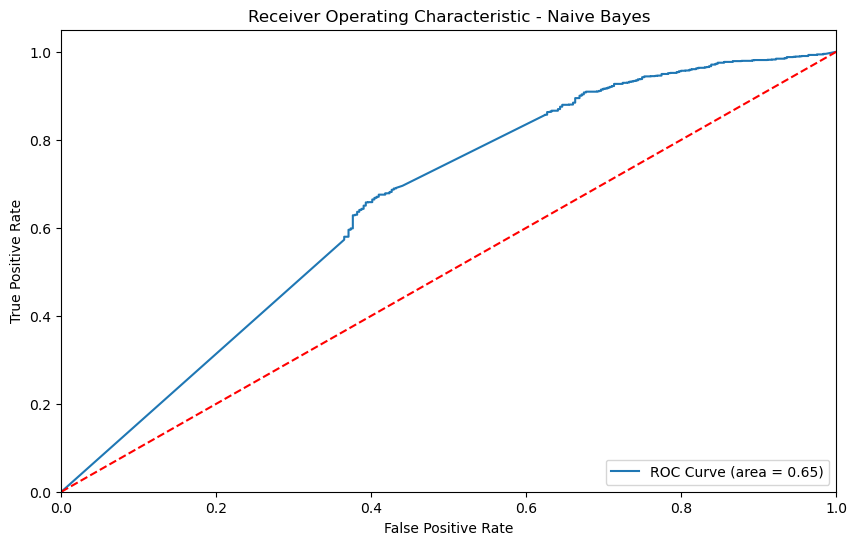

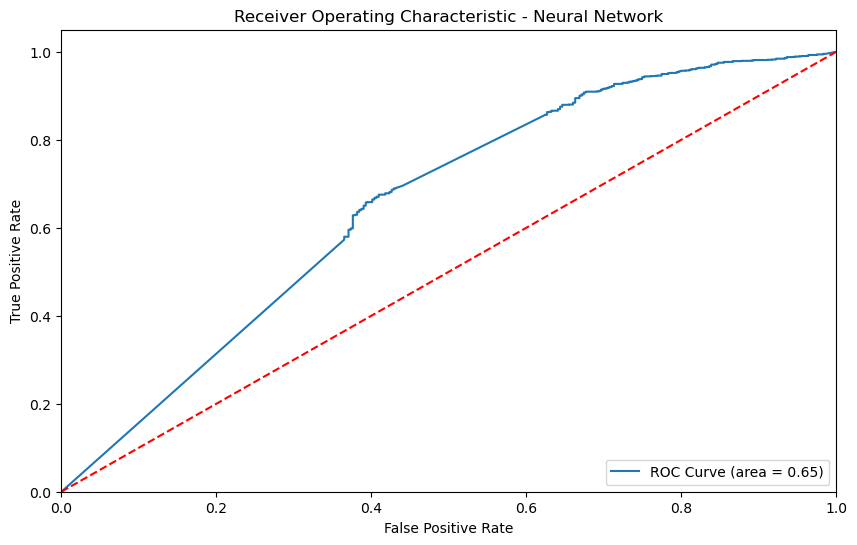

Top Positive Features:
50: 7.038128838319591
323: 6.8252010030450805
1268: 6.822866719618062
454: 6.803204032652431
2936: 6.735814213993198
3590: 6.731504917875576
3995: 6.7265905990607955
2313: 6.7128240560109305
4753: 6.68760909756231
192: 6.674092538712369
4340: 6.662252233998302
4971: 6.654053973636614
80: 6.653532862943575
4518: 6.646844995894746
674: 6.639008792767498
4143: 6.621964216212454
2387: 6.610610919204344
3826: 6.6009748762637095
4404: 6.597469776471691
3690: 6.594289092757059

Top Negative Features:
1205: -8.801032606492484
4707: -8.739739034299244
3707: -8.734847055991931
1374: -8.714915638179846
3811: -8.709484572332162
4741: -8.654231198507375
1269: -8.605257067726319
4680: -8.557946775672143
112: -8.552213264549579
2219: -8.511951518295538
4950: -8.511542075468986
2213: -8.505570585989718
3531: -8.490567803833688
3756: -8.485564404811877
2768: -8.484399540839654
2539: -8.475259340143538
2113: -8.459747520188593
1531: -8.457631354895788
887: -8.334626546089229
789: 

In [61]:
nb_model, nb_metrics = evaluate_naive_bayes_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst)

c:\Users\jason\anaconda3\envs\itcs-3156\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.5699 - loss: 1.5597 - val_accuracy: 0.8185 - val_loss: 1.1233
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7552 - loss: 1.2061 - val_accuracy: 0.8220 - val_loss: 1.1177
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8276 - loss: 1.1131 - val_accuracy: 0.8345 - val_loss: 1.0994
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8638 - loss: 1.0238 - val_accuracy: 0.8290 - val_loss: 1.1360
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.8964 - loss: 0.9242 - val_accuracy: 0.8325 - val_loss: 1.1584
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9201 - loss: 0.8368 - val_accuracy: 0.8330 - val_loss: 1.1578
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9301 - loss: 0.7672 - val_accuracy: 0.8275 - val_loss: 1.1567
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9397 - loss: 0.6930 - val_ac

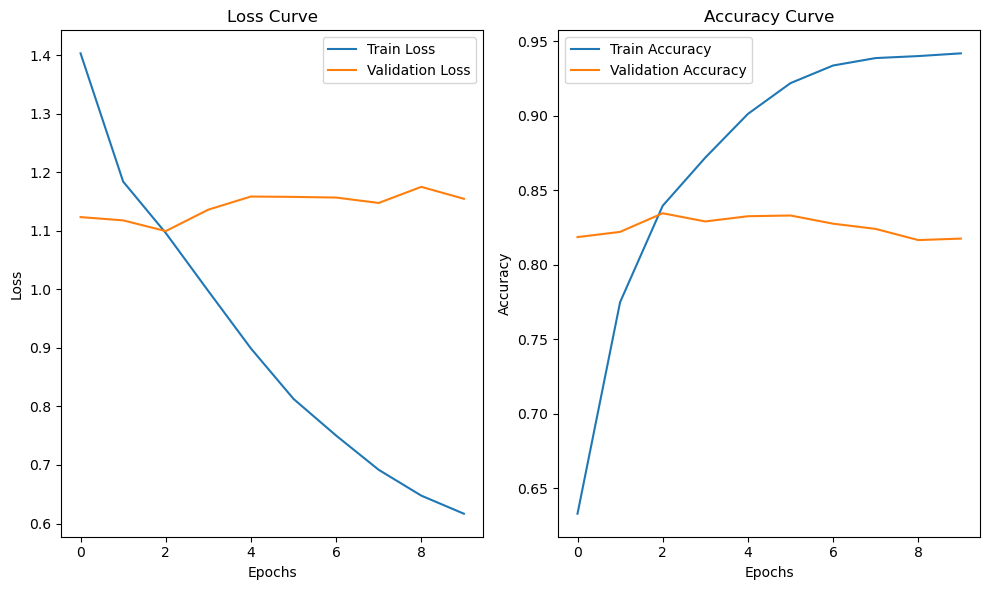

Validation Accuracy: 0.8175
Validation Precision: 0.861268403171008
Validation Recall: 0.926873857404022
Validation F1 Score: 0.8928676254769592
Validation ROC AUC: 0.7184295532821043


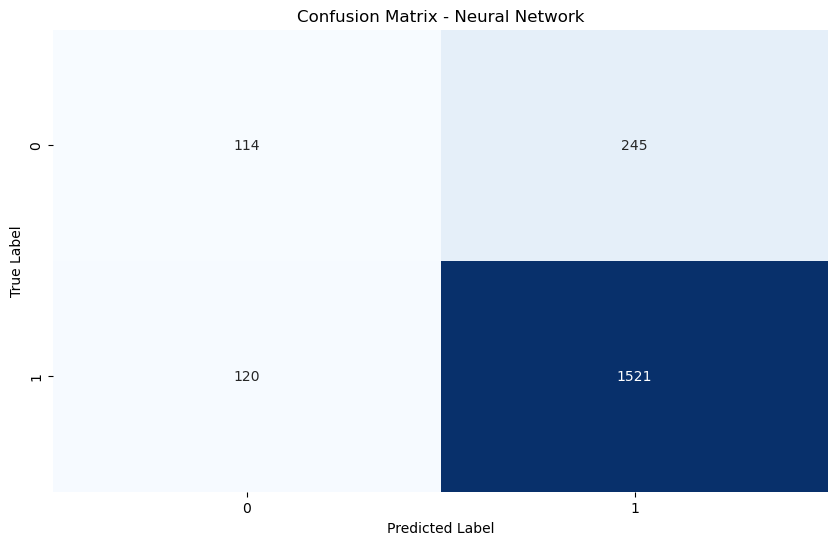

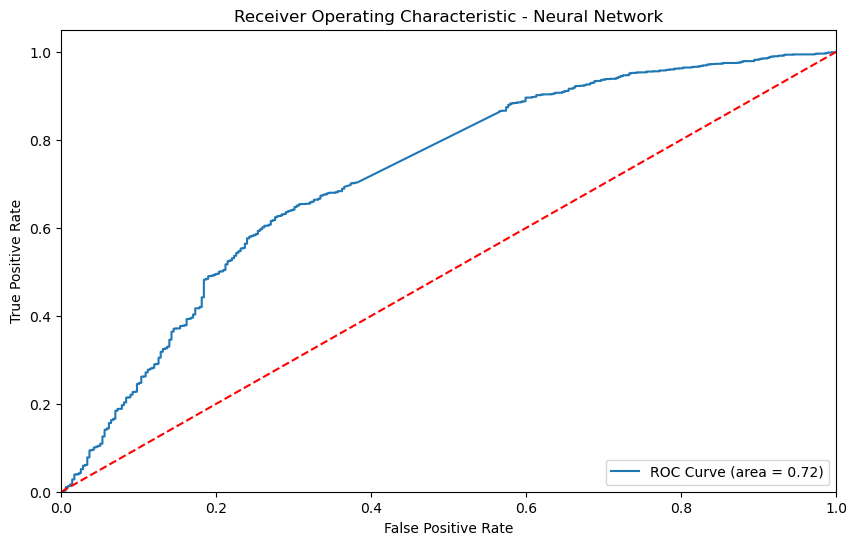

Test Accuracy: 0.821
Test Precision: 0.8595600676818951
Test Recall: 0.9332516840171463
Test F1 Score: 0.8948913681738109
Test ROC AUC: 0.7218389116835834


In [62]:
nn_model, nn_metrics = evaluate_neural_network_model(X_trn, y_trn, X_vld, y_vld, X_tst, y_tst)

Model Comparison - Test Metrics
           Naive Bayes  Neural Network
accuracy      0.763000        0.821000
precision     0.852708        0.859560
recall        0.857930        0.933252
f1_score      0.855311        0.894891
roc_auc       0.641312        0.721839


<Figure size 1000x600 with 0 Axes>

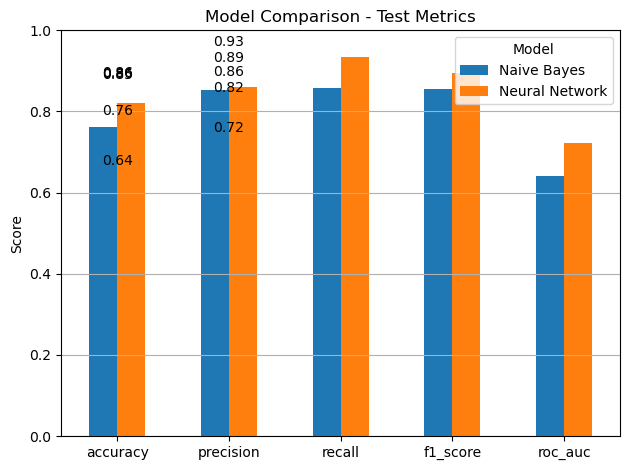

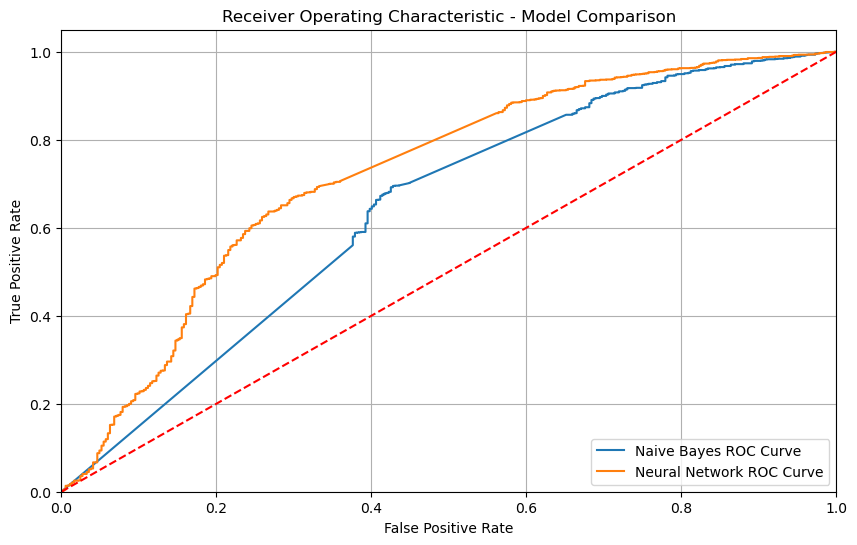

In [63]:
compare_models(nb_metrics, nn_metrics)

In [64]:
print('Error Analysis (Naive Bayes):')
analyze_model_performance(nb_model, X_tst, y_tst, vectorizer, steam_reviews_df.iloc[X_tst.index] if hasattr(X_tst, 'index') else steam_reviews_df)

Error Analysis (Naive Bayes):
Misclassified Samples (10):

Sample 1
Review:  Early Access Review...
Actual Sentiment: Positive
Predicted Sentiment: Negative

Sample 2
Review:  Early Access Review...
Actual Sentiment: Positive
Predicted Sentiment: Negative

Sample 3
Review: I get a little freeked out when falling in games. This game had my butt clenched, breathing stop, bug eyes, hope you make the platform 87% of the time. The story was good, simple, good. Spent some tim...
Actual Sentiment: Positive
Predicted Sentiment: Negative

Sample 4
Review: Keep in mind, i have finished the game after writing this review. This game is broken. If you hate games that feel like they havent been tested, then stay away. There are countless glitches in this ga...
Actual Sentiment: Positive
Predicted Sentiment: Negative

Sample 5
Review:  Early Access Review...
Actual Sentiment: Positive
Predicted Sentiment: Negative

Sample 6
Review:  Early Access Review...
Actual Sentiment: Positive
Predicted Sentimen

In [65]:
print('Error Analysis (Neural Network):')
analyze_model_performance(nn_model, X_tst, y_tst, vectorizer, steam_reviews_df.iloc[X_tst.index] if hasattr(X_tst, 'index') else steam_reviews_df)

Error Analysis (Neural Network):
Misclassified Samples (10):

Sample 1
Review: A mind Boggling puzzling in which you play as a simple immigrant guard, simply checking to see if these guys are valid for entry. A dude put c4 on my desk. and i had to disarm it. They could be terror...
Actual Sentiment: Positive
Predicted Sentiment: Negative
Predicted Probability: 0.30109745264053345

Sample 2
Review: One of the best games ever....
Actual Sentiment: Negative
Predicted Sentiment: Positive
Predicted Probability: 0.8807658553123474

Sample 3
Review: Best game I played on PC all of 2013 and now with 2 DLC for 2014. Elizabeth is a superbly imagined and the best 'sidekick' ever in a game. Just love the imagery and storyline. Genuinely sad when I fin...
Actual Sentiment: Positive
Predicted Sentiment: Negative
Predicted Probability: 0.34164100885391235

Sample 4
Review: This game is really fun. The campaign may a little tricky, but it's a great game nonetheless, and it's even better if you do mult

In [66]:
if nb_metrics['test']['f1_score'] > nn_metrics['test']['f1_score']:
    print('Naive Bayes performed better on the test set.')
    best_model = nb_model
    best_metrics = nb_metrics
else:
    print('Neural Network performed better on the test set.')
    best_model = nn_model
    best_metrics = nn_metrics

print(f"Best Model F1-Score: {best_metrics['test']['f1_score']}")
print(f"Best Model Accuracy: {best_metrics['test']['accuracy']}")

Neural Network performed better on the test set.
Best Model F1-Score: 0.8948913681738109
Best Model Accuracy: 0.821
